In [1]:
# Importing the required libraries.
import pandas as pd
import numpy as np
import pickle
import zlib
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Loading the images data.
file = open('drive/My Drive/Autonomous Driving Vehicle/Dataset/Dataset_Images_1','rb')
data_images = pickle.loads(zlib.decompress(pickle.load(file)))
file.close()
for i in range(2,6):
    file = open('drive/My Drive/Autonomous Driving Vehicle/Dataset/Dataset_Images_'+str(i),'rb')
    data_images = np.concatenate((data_images, pickle.loads(zlib.decompress(pickle.load(file)))))
    file.close()
print(data_images.shape)

(45405, 200, 200, 3)


In [3]:
# Loading the angles data.
file = open('drive/My Drive/Autonomous Driving Vehicle/Dataset/Angles','rb')
data_angles = pickle.loads(zlib.decompress(pickle.load(file)))
file.close()
print(data_angles.shape)

(45405,)


In [4]:
# Preprocessing the data.
for i in range(len(data_images)):
    data_images[i] = data_images[i]/255
data_angles = data_angles*(np.pi/180.0)

# Printing the shapes of our dataset.
print(data_images.shape, data_angles.shape)

(45405, 200, 200, 3) (45405,)


In [5]:
# Creating our model.
model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(200,200,3)),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512,activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64,activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1)
])
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       1

In [6]:
# Training our model.
history = model.fit(data_images, data_angles, batch_size=100, epochs=30)

Epoch 1/30
455/455 [==============================] - 162s 355ms/step - loss: 0.2027
Epoch 2/30
455/455 [==============================] - 161s 353ms/step - loss: 0.1087
Epoch 3/30
455/455 [==============================] - 161s 354ms/step - loss: 0.0635
Epoch 4/30
455/455 [==============================] - 161s 354ms/step - loss: 0.0487
Epoch 5/30
455/455 [==============================] - 161s 354ms/step - loss: 0.0448
Epoch 6/30
455/455 [==============================] - 161s 353ms/step - loss: 0.0352
Epoch 7/30
455/455 [==============================] - 160s 353ms/step - loss: 0.0408
Epoch 8/30
455/455 [==============================] - 160s 352ms/step - loss: 0.0380
Epoch 9/30
455/455 [==============================] - 160s 352ms/step - loss: 0.0279
Epoch 10/30
455/455 [==============================] - 160s 352ms/step - loss: 0.0347
Epoch 11/30
455/455 [==============================] - 160s 352ms/step - loss: 0.0424
Epoch 12/30
455/455 [==============================] - 160s 352

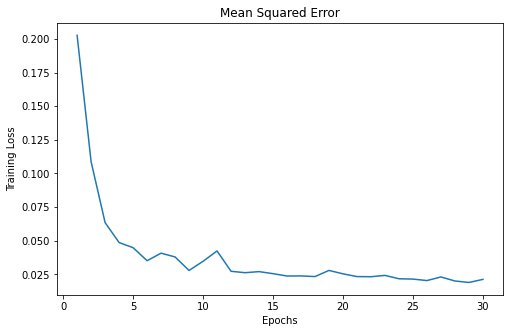

In [7]:
# Plotting the loss, here MSE.
loss = history.history['loss']
plt.figure(figsize=(8,5))
plt.plot(range(1,len(loss)+1), loss)
plt.ylabel('Training Loss')
plt.xlabel('Epochs')
plt.title('Mean Squared Error')
plt.savefig('./drive/My Drive/Autonomous Driving Vehicle/Results/training_loss.jpg')
plt.show()

In [8]:
# Obtaining the predictions and saving the model.
predictions = model.predict(data_images)
model.save('./drive/My Drive/Autonomous Driving Vehicle/Results/model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./drive/My Drive/Autonomous Driving Vehicle/Results/model/assets


In [9]:
# Smoothening out the curve.
value = 5
temp = list(predictions[:value])
for i in range(value,len(predictions)-value):
    temp.append(np.sum(predictions[i-value:i+value])/(2*value+1))
temp = temp + list(predictions[-value:])
temp = np.array(temp)
print(temp.shape)

# Saving the predictions.
file = open('./drive/My Drive/Autonomous Driving Vehicle/Results/predictions.txt','w')
for i in range(len(temp)):
    file.write(str(i)+'.jpg, '+str(temp[i])+'\n')
file.close()

(45405,)


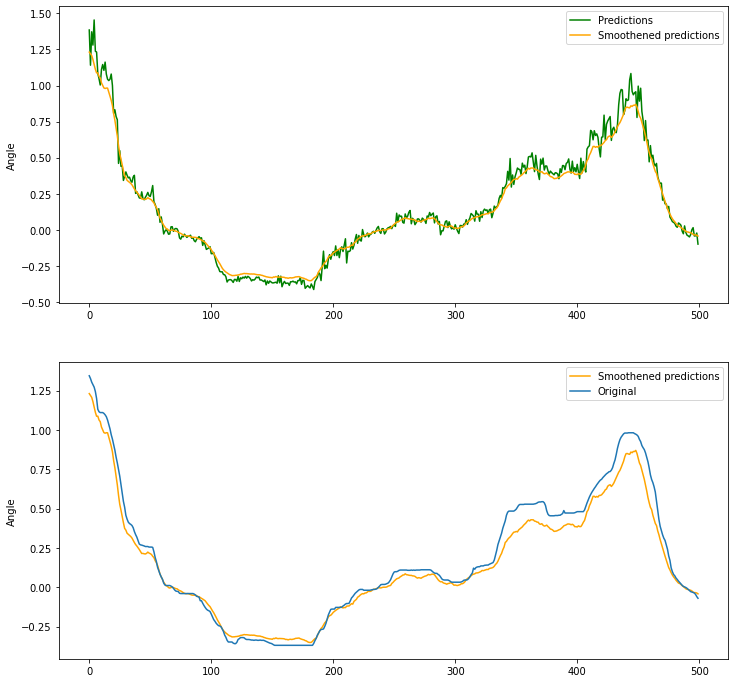

In [10]:
# Plotting the values for smoothening the curve and comparision.
value = 35100
points = 300
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.ylabel('Angle')
plt.plot(predictions[value:value+points], 'g', label='Predictions')
plt.plot(temp[value:value+points], 'orange', label='Smoothened predictions')
plt.legend()
plt.subplot(212)
plt.ylabel('Angle')
plt.plot(temp[value:value+points], 'orange', label='Smoothened predictions')
plt.plot(data_angles[value:value+points], label='Original')
plt.legend()
plt.savefig('./drive/My Drive/Autonomous Driving Vehicle/Results/prediction_curves.jpg')
plt.show()